Working Notebook to try things and donwload data from the quandl and tiingo

In [284]:
import pandas_datareader.data as web
import pandas_datareader as pdr
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from empyrical import max_drawdown, annual_return, cagr, omega_ratio
from matplotlib.ticker import FixedLocator
from scipy.stats import geom
import math
import streamlit as st
from matplotlib.pyplot import rc
import datetime
import pandas_market_calendars as mcal

In [56]:
symbol_oil = "EIA/PET_RWTC_D"
df_oil = web.DataReader(symbol_oil, 'quandl', '2000-01-01', '2021-02-12', api_key = quandl_key)
df_oil.to_csv("Oil_original.csv")
df_oil.reset_index().to_csv("Oil_flattened.csv")

In [178]:
df_spy = pdr.get_data_tiingo('SPY', '2000-01-01', end='2021-02-12', api_key=tiingo_key)
df_spy.to_csv("SPY_original.csv")
df_spy.reset_index().to_csv("SPY_flattened.csv",index=False)

In [387]:
df_gld = pdr.get_data_tiingo('GLD', '2000-01-01', end='2021-02-12', api_key=tiingo_key)
df_gld.to_csv("GLD_original.csv")
df_gld.reset_index().to_csv("GLD_flattened.csv",index=False)

In [1]:
df_vglt = pdr.get_data_tiingo('VGLT', '2000-01-01', '2021-02-12', api_key=tiingo_key)
df_vglt.to_csv("VGLT_original.csv")
df_vglt.reset_index().to_csv("VGLT_flattened.csv")

NameError: name 'pdr' is not defined

In [245]:
def read_data(file):
    data = pd.read_csv(file,parse_dates=['date'])
    data['date'] = data['date'].dt.tz_convert(None)
    data = data.set_index('date')
    return data


In [435]:
def price_diff_loaded(dataset, startDate, endDate, dayprice = 'open'):
    '''
    Function takes in the dataset for a particular asset class, start and end dates, dayprice to use and calculates the absolute price change (in $)
    '''
    price_diff = dataset.loc[endDate,dayprice] - dataset.loc[startDate,dayprice]
    return price_diff

def price_ratio_loaded(dataset, startDate, endDate, dayprice = 'open'):
    '''
    Function takes in the dataset for a particular asset class, start and end dates, dayprice to use and calculates the relative price change
    '''
    price_ratio = dataset.loc[endDate,dayprice]/dataset.loc[startDate,dayprice]        
    return price_ratio

def dollar_cost_average_loaded(dataset, startDate, endDate, initial_investment = 0, regular_invest = 1000, freq = 10, dayprice = 'open'):
    '''
    Function takes in the dataset for a particular asset class, start and end dates, dayprice to use and calculates final value of the portfolio as a result of the dollar cost averaging
    '''
 
    dict_list = []
   
    invested = [] #tracks amount of invested capital up to this point
    portfolio_value = [] #track protfolio value
    nyse = mcal.get_calendar('NYSE')
    early = nyse.schedule(start_date=startDate, end_date=endDate)
    startDate = early.index[0]
    endDate = early.index[-1]
    dca_dates = list(early[::freq].index)
    #dca_dates = investment_dates_all = pd.bdate_range(start = startDate, end = endDate, freq = str(freq)+"B") #tracks the days when regular investment is made
    
    current_value = initial_investment*price_ratio_loaded(dataset, startDate, startDate, dayprice) 
    
    value_at_the_end = initial_investment*price_ratio_loaded(dataset, startDate, endDate, dayprice)
    invested = initial_investment
    portfolio_value = [current_value]
    dates = [startDate]
    previous_date = startDate
    
    history_dict = {'dates':startDate,'invested':initial_investment,'value_at_end':value_at_the_end,'current_value':current_value}
    dict_list.append(history_dict)
    
    for date in dca_dates[1:]:
        #add to the sum to track both current and at the end values of the portfolio
        current_value = current_value*price_ratio_loaded(dataset, startDate = previous_date, endDate = date, dayprice = dayprice) + regular_invest 
        value_at_the_end += price_ratio_loaded(dataset, startDate = date, endDate = endDate, dayprice = dayprice)*regular_invest 
        invested += regular_invest
        #log invested, portfolio_value
        tmp_dict = {'dates':date,'invested':invested,'value_at_end':value_at_the_end,'current_value':current_value}
        dict_list.append(tmp_dict)
        previous_date = date   
    current_value = current_value*price_ratio_loaded(dataset, startDate = date, endDate = endDate, dayprice = dayprice)
    tmp_dict = {'dates':endDate,'invested':invested,'value_at_end':value_at_the_end,'current_value':current_value}
    dict_list.append(tmp_dict)
    return pd.DataFrame(dict_list)  

   
def hold_overnight_ratio(dataset, startDate, endDate):
    '''
    This function calculates the difference assuming
    '''
    price_ratio_list = (dataset.loc[startDate:endDate,'open'][1:] - dataset.loc[startDate:endDate,'close'][:-1])/(dataset.loc[startDate:endDate,'close'][:-1]+0.000001)
    running_price_ratio = np.cumprod(1 + price_ratio_list)
    price_ratio = np.prod(1+price_ratio_list)
    return price_ratio, price_ratio_list, running_price_ratio 

def dollar_cost_average_hold_overnight(dataset, startDate, endDate, initial_investment = 0, regular_invest = 1000, freq = 10):
    '''
    Function takes in the dataset for a particular asset class, start and end dates, dayprice to use and calculates final value of the portfolio as a result of the dollar cost averaging
    ''' 
 
    dict_list = []

    nyse = mcal.get_calendar('NYSE')
    early = nyse.schedule(start_date=startDate, end_date=endDate)
    startDate = early.index[0]
    endDate = early.index[-1]
    dca_dates = list(early[::freq].index)
    #dca_dates = investment_dates_all = pd.bdate_range(start = startDate, end = endDate, freq = str(freq)+"B") #tracks the days when regular investment is made
    
    current_value = initial_investment*hold_overnight_ratio(dataset, startDate, startDate)[0] 
    
    value_at_the_end = initial_investment*hold_overnight_ratio(dataset, startDate, endDate)[0]
    invested = initial_investment
    previous_date = startDate
    
    history_dict = {'dates':startDate,'Invested':initial_investment,'Portfolio Value':current_value}
    dict_list.append(history_dict)
    
    for date in dca_dates[1:]:
        #add to the sum to track both current and at the end values of the portfolio
        current_value = current_value*hold_overnight_ratio(dataset, startDate = previous_date, endDate = date)[0] + regular_invest 
        invested += regular_invest
        #log invested, portfolio_value
        tmp_dict = {'dates':date,'Invested':invested,'Portfolio Value':current_value}
        dict_list.append(tmp_dict)
        previous_date = date   
    current_value = current_value*hold_overnight_ratio(dataset, startDate = date, endDate = endDate)[0]
    tmp_dict = {'dates':endDate,'Invested':invested,'Portfolio Value':current_value}
    dict_list.append(tmp_dict)
    return pd.DataFrame(dict_list).set_index('dates')


   
def dont_hold_overnight_ratio(dataset, startDate, endDate):
    '''
    This function calculates the difference assuming
    '''
    price_ratio_list = (dataset.loc[startDate:endDate,'close'] - dataset.loc[startDate:endDate,'open'])/(dataset.loc[startDate:endDate,'open']+0.000001)
    running_price_ratio = np.cumprod(1 + price_ratio_list)
    price_ratio = np.prod(1+price_ratio_list)
    return price_ratio, price_ratio_list, running_price_ratio 

def dollar_cost_average_dont_hold_overnight(dataset, startDate, endDate, initial_investment = 0, regular_invest = 1000, freq = 10):
    '''
    Function takes in the dataset for a particular asset class, start and end dates, dayprice to use and calculates final value of the portfolio as a result of the dollar cost averaging
    ''' 
 
    dict_list = []

    nyse = mcal.get_calendar('NYSE')
    early = nyse.schedule(start_date=startDate, end_date=endDate)
    startDate = early.index[0]
    endDate = early.index[-1]
    dca_dates = list(early[::freq].index)
    #dca_dates = investment_dates_all = pd.bdate_range(start = startDate, end = endDate, freq = str(freq)+"B") #tracks the days when regular investment is made
    
    current_value = initial_investment*dont_hold_overnight_ratio(dataset, startDate, startDate)[0] 
    
    value_at_the_end = initial_investment*dont_hold_overnight_ratio(dataset, startDate, endDate)[0]
    invested = initial_investment
    previous_date = startDate
    
    history_dict = {'dates':startDate,'Invested':initial_investment,'Portfolio Value':current_value}
    dict_list.append(history_dict)
    
    for date in dca_dates[1:]:
        #add to the sum to track both current and at the end values of the portfolio
        current_value = current_value*dont_hold_overnight_ratio(dataset, startDate = previous_date, endDate = date)[0] + regular_invest 
        invested += regular_invest
        #log invested, portfolio_value
        tmp_dict = {'dates':date,'Invested':invested,'Portfolio Value':current_value}
        dict_list.append(tmp_dict)
        previous_date = date   
    current_value = current_value*dont_hold_overnight_ratio(dataset, startDate = date, endDate = endDate)[0]
    tmp_dict = {'dates':endDate,'Invested':invested,'Portfolio Value':current_value}
    dict_list.append(tmp_dict)
    return pd.DataFrame(dict_list).set_index('dates')

In [436]:
df_dont_hold_overnight = dollar_cost_average_dont_hold_overnight(df_spy, startDate=datetime.datetime(2018,7,10), endDate=datetime.datetime(2021,1,1))

In [444]:
(df_dont_hold_overnight.index[-1] - df_dont_hold_overnight.index[0]).days

905

In [407]:
df_hold_overnight = dollar_cost_average_hold_overnight(df_spy, startDate=datetime.datetime(2018,7,10), endDate=datetime.datetime(2021,1,1))

In [424]:
df_hold_open = dollar_cost_average_loaded(df_spy, startDate='2018-07-05', endDate='2021-01-01')

In [425]:
df_hold_close = dollar_cost_average_loaded(df_spy, startDate='2018-07-05', endDate='2021-01-01', dayprice = 'close')

In [426]:
df_hold_open

,dates,invested,value_at_end,current_value
0,2018-07-05,0,0.000000,0.000000
1,2018-07-19,1000,1326.317292,1000.000000
2,2018-08-02,2000,2657.001998,1996.717919
3,2018-08-16,3000,3968.858031,3025.376207
4,2018-08-30,4000,5246.716009,4105.867867
...,...,...,...,...
59,2020-11-05,59000,74547.825565,70028.195708
60,2020-11-19,60000,75593.326128,72303.477247
61,2020-12-04,61000,76605.468129,75686.482740
62,2020-12-18,62000,77607.651594,77438.567195


[   0.            0.          -11.81779484    4.96239949   19.10405596
   12.63246553   -3.34155213   28.594132     22.61009087   42.17688055
  -53.42455349  133.98632412 -407.7336081   -74.1450084    43.80443008
  -34.87286805  128.51035437 -129.1447552    58.44734551   26.63381182
  -77.00062122  243.24177492   21.84657221   24.89002602   37.64162997
  -56.96567114  -58.75756501  350.96729011  103.24975304   -3.81752229
  159.40707615  344.00124538   74.91071586 -134.16280674  -47.82509646
  105.58578958  159.55312989  137.54581212 -105.65381538  -47.68987851
   91.67541745  377.77323738 -526.72560143 2072.33805815  405.93969573
  169.63197357 -434.74267932 -292.65836916 -222.5890312   455.23695626
 -719.22647276  138.82495197 -490.16166728 -308.38479912 -454.79583891
 1537.84991302 -390.13649386 -128.21960802 -268.3024297  -138.883542
 -374.16555234 -442.99959359  446.99686128 -364.09204444]


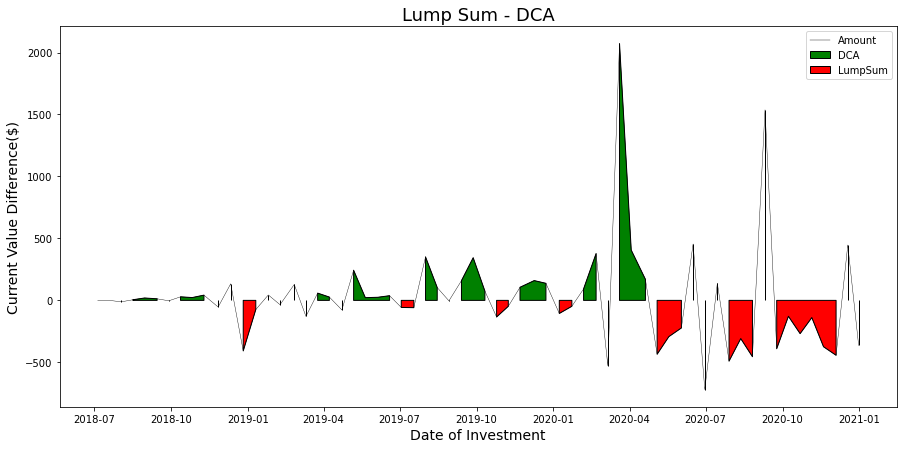

In [429]:
def plot_the_difference(df1, df2, name1, name2):
    '''
    '''
    difference = np.array(df1[''])
    
df_hold_open = df_hold_open.resample('12H')
    
# Get difference with array operations
difference = np.array(df_hold_open['current_value']) - np.array(df_hold_close['current_value'])
print(difference)
# Style and size
fig, ax = plt.subplots()
#sns.set_style("whitegrid")
fig.set_size_inches(15, 7)

# Plot Series
ax.fill_between(df_hold_open['dates'], y1=difference, y2=0, color='green', where=difference > 0, edgecolor='black')
ax.fill_between(df_hold_open['dates'], y1=difference, y2=0, color='red', where=difference < 0, edgecolor='black')
ax.plot(df_hold_open['dates'], difference, color='black', linewidth=.4)

ax.set_title('Lump Sum - DCA', size=18)
ax.set_ylabel('Current Value Difference($)', size=14)
ax.set_xlabel('Date of Investment', size=14)

plt.legend(['Amount','DCA','LumpSum'])
#plt.savefig('difference.png')
plt.show()